<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project2_transport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 2: Tracer transport

A critical aspect of understanding climate and environmental systems is describing the movement of substances. This could include pollution or water vapor in the atmosphere, salt in an estuary, or chemicals in a river. We often model the transport of these substances using an advection/diffusion equation for the concentration of the substance. In this context, we sometimes refer to the concentration field as a `tracer' since it helps us track the movement of individual molecules. We can also use this framework to describe the transport of heat, although in this case the tracer field (temperature or heat content) tracks the movement of thermal energy.

In this project we will use Dedalus to solve advection diffusion equations to describe the vertical distribution of heat in the ocean and the concentration of pollution in a river.

Student tasks are in [Section 1.4](#section1pt4), [Section 1.6](#section1pt6), and [Section 2.3](#section2pt3)

## Setup
If you are using Google colab, run the script below to install Dedalus

In [1]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus not installed yet.
Installing for Google Colab.

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libfftw3-bin libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
Suggested packages:
  libfftw3-doc
The following NEW packages will be installed:
  libfftw3-bin libfftw3-dev libfftw3-double3 libfftw3-long3 libfftw3-quad3 libfftw3-single3
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,654 kB of archives.
After this operation, 24.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-double3 amd64 3.3.8-2ubuntu8 [770 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-long3 amd64 3.3.8-2ubuntu8 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfftw3-quad3 amd64 3.3.8-2ubuntu8 [614 kB]
Get:4 http://archiv

## 1. Thermal structure in the ocean

Most of the ocean has a stable thermal stratification with warm water at the surface and cold water in the abyss (exceptions occur in salt-stratified waters like the Arctic Ocean). Since the ocean is a massive thermal reservoir, understanding the distribution of this heat is important to quantifying the ocean's role in a changing climate. The structure of the temperature field can also inform us about the circulation in the ocean interior.


### 1.1 Measured temperature profile

The code below plots a sample temperature profile obtained off the coast of California. The data was obtained by digitizing Figure 3 in Munk, 1966.

Text(0, 0.5, 'Depth (m)')

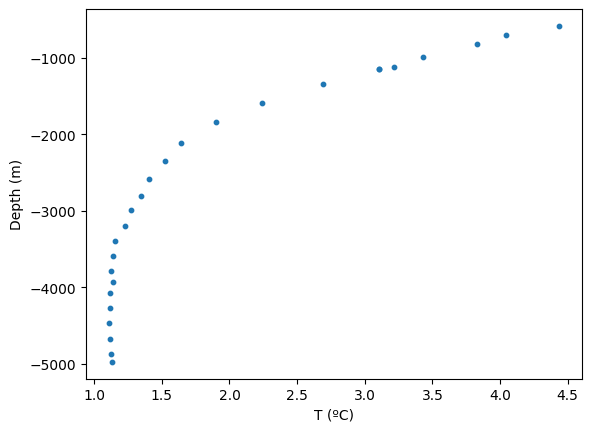

In [2]:
import matplotlib.pyplot as plt

# Temperature measurements extracted from Figure 3 in Munk, 1966
CTD_T = [1.1296296296296295, 1.122004357298475, 1.1143790849673203, 1.1067538126361656, 1.1143790849673203, 1.1143790849673203, 1.1372549019607843, 1.122004357298475, 1.1372549019607843, 1.1525054466230937, 1.2287581699346406, 1.2745098039215685, 1.343137254901961, 1.4041394335511983, 1.526143790849673, 1.6405228758169934, 1.8997821350762527, 2.242919389978214, 2.69281045751634, 3.104575163398693, 3.104575163398693, 3.218954248366013, 3.4324618736383443, 3.8289760348583877, 4.042483660130719, 4.438997821350762]
CTD_z = [-4976.958525345623, -4869.431643625192, -4677.419354838709, -4470.046082949309, -4270.353302611367, -4070.6605222734256, -3932.411674347158, -3786.4823348694317, -3586.78955453149, -3394.7772657450078, -3195.084485407066, -2995.3917050691243, -2803.379416282642, -2580.6451612903224, -2350.230414746544, -2112.1351766513058, -1843.3179723502303, -1597.5422427035332, -1344.0860215053763, -1144.3932411674346, -1144.3932411674346, -1121.351766513057, -990.7834101382491, -821.8125960061443, -698.9247311827958, -583.7173579109067]

plt.scatter(CTD_T,CTD_z,s=10)
plt.xlabel('T (ºC)')
plt.ylabel('Depth (m)')


### 1.2 Abyssal recipes

Munk (1966) proposed that the thermal structure of the ocean interior is set by a balance between upwelling and diffusion. In this view, cold waters sink near the poles and spread across the seafloor before slowly rising through the ocean interior. If we assume, as Munk did, that the water upwells uniformly across the globe, the upwelling speed is approximately $10^{-7}$ m/s. This is far too small to directly measure, but it is large enough to have a major impact on the distribution of tracers. Since light can only penetrate through the top ~100m of ocean, we can ignore solar heating, except in that it sets the temperature near the ocean surface.

### 1.3 Steady advection/diffusion equation

Dedalus can solve differential equations in various forms. In addition to time-dependent initial value problems (IVPs), Dedalus can solve linear and nonlinear boundary value problems. The code below uses Dedalus to solve a linear boundary value problem (IVBP) for the steady state advection/diffusion equation.

Here, the top and bottom temperature are set from the measured profile and these are used as boundary conditions. The vertical (upwelling) velocity is set to $10^{-7} m/s$, and the diffusivity is set to $10^{-7}$ $m^2/s$, to approximate the molecular diffusivity of heat in seawater.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.4e+00/s


2024-11-08 14:46:41,675 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 6.4e+00/s


Text(0, 0.5, 'Depth (m)')

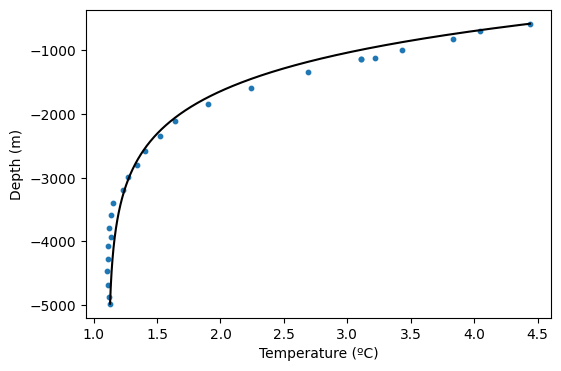

In [3]:
"""
Dedalus script to solve the steady advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the upwelling velocity
w = 1e-7 # m/s
# Set the diffusivity
kappa=8e-5 # m^2/s originally 1e-7

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - kappa*Tzz = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


2024-11-08 15:11:29,430 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


2024-11-08 15:11:29,537 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


2024-11-08 15:11:29,632 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-11-08 15:11:29,746 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


2024-11-08 15:11:29,848 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-11-08 15:11:29,958 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


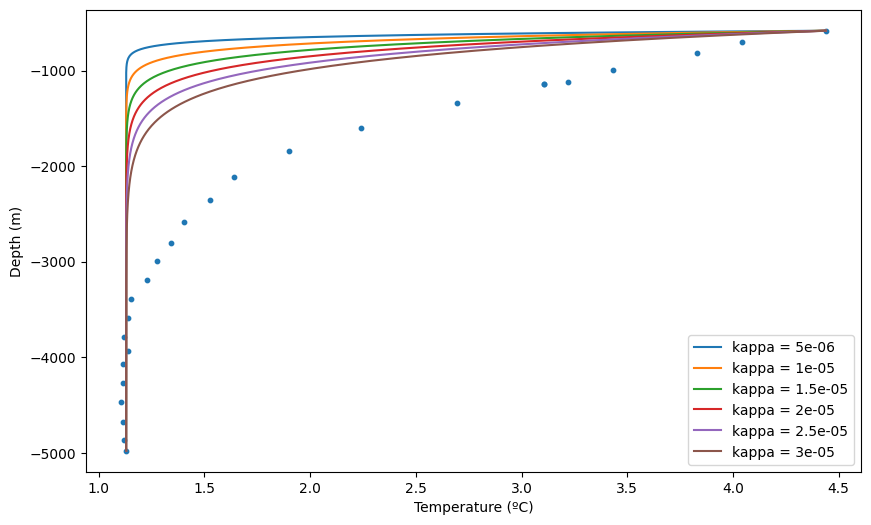

In [7]:
import logging
import os
import dedalus.public as de
from google.colab import output
import matplotlib.pyplot as plt
import numpy as np
import dedalus.public as d3

# ... (Your existing code for setup and CTD data) ...

# Set the upwelling velocity
w = 1e-7  # m/s
# Set the diffusivity values
kappa_values = [0.000005, 0.00001, 0.000015, 0.00002, 0.000025, 0.00003]
#kappa_values = [1e-4, 6.8e-5, 6e-5, 8e-5, 1e-5, 5e-4]

# Create a figure and axes
plt.figure(figsize=(10, 6))

# Loop through different kappa values and solve the problem
for kappa in kappa_values:
    # Bases
    zcoord = d3.Coordinate('z')
    dist = d3.Distributor(zcoord, dtype=np.float64)
    zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
    z = dist.local_grid(zbasis)

    # Fields
    T = dist.Field(name='T', bases=zbasis)

    # Add two tau variables to allow us to apply two boundary conditions
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)

    # Substitutions
    dz = lambda A: d3.Differentiate(A, zcoord)
    Tz = dz(T) + lift(tau_1)
    Tzz = dz(Tz) + lift(tau_2)

    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - kappa*Tzz = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Plot
    Tg = T['g']
    plt.plot(Tg, z, label=f'kappa = {kappa}')

# Add labels and legend
plt.scatter(CTD_T, CTD_z, s=10)
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')
plt.legend()
plt.show()

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-11-08 15:12:20,293 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


2024-11-08 15:12:20,408 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-11-08 15:12:20,518 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-11-08 15:12:20,632 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


2024-11-08 15:12:20,730 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


2024-11-08 15:12:20,829 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


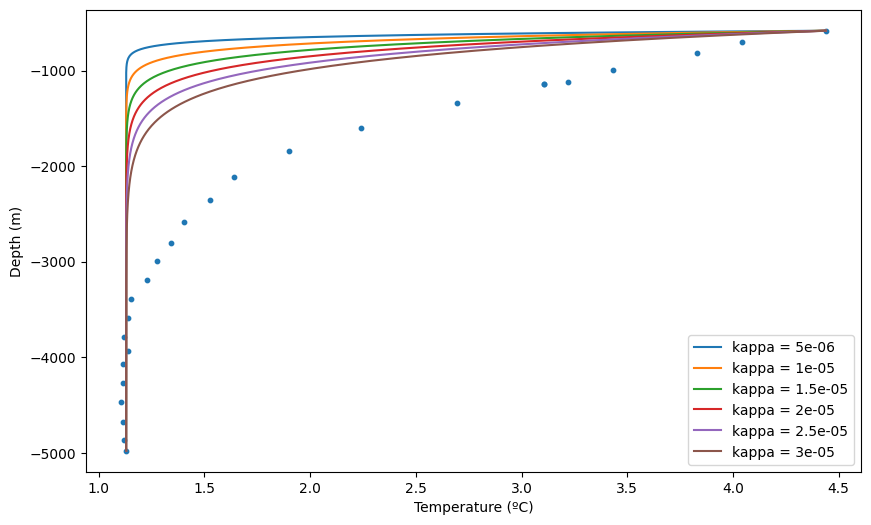

In [8]:
# Set the upwelling velocity
w = 1e-7  # m/s
# Set the diffusivity values
kappa_values = [0.000005, 0.00001, 0.000015, 0.00002, 0.000025, 0.00003]
#kappa_values = [1e-4, 6.8e-5, 6e-5, 8e-5, 1e-5, 5e-4]

# Create a figure and axes
plt.figure(figsize=(10, 6))

# Loop through different kappa values and solve the problem
for kappa in kappa_values:
    # Bases
    zcoord = d3.Coordinate('z')
    dist = d3.Distributor(zcoord, dtype=np.float64)
    zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
    z = dist.local_grid(zbasis)

    # Fields
    T = dist.Field(name='T', bases=zbasis)

    # Add two tau variables to allow us to apply two boundary conditions
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)

    # Substitutions
    dz = lambda A: d3.Differentiate(A, zcoord)
    Tz = dz(T) + lift(tau_1)
    Tzz = dz(Tz) + lift(tau_2)

    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - kappa*Tzz = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Plot
    Tg = T['g']
    plt.plot(Tg, z, label=f'kappa = {kappa}')

# Add labels and legend
plt.scatter(CTD_T, CTD_z, s=10)
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')
plt.legend()
plt.show()

The diffusion equation scales to z~kappa/u, so we expect the characteristic length of diffusion, or the depth to which heat penetrates to increase linearly with kappa. In the experimental data, this lengthscale is around 3500m deep, so theoretically, the diffusivity should give this lengthscale. I am plotting solutions for linearly increasing kappa.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+00/s


2024-11-08 15:12:40,006 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.2e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+00/s


2024-11-08 15:12:40,374 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.5e+00/s


2024-11-08 15:12:40,698 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s


2024-11-08 15:12:41,020 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-11-08 15:12:41,295 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


2024-11-08 15:12:41,561 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+00/s


2024-11-08 15:12:41,897 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


2024-11-08 15:12:42,266 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.5e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+00/s


2024-11-08 15:12:42,610 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.8e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


2024-11-08 15:12:43,007 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.2e+00/s


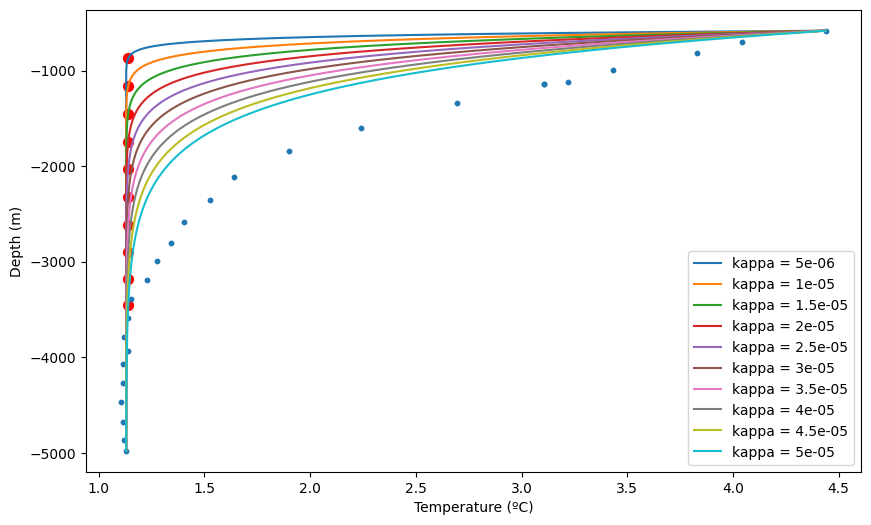

In [9]:
# Set the upwelling velocity
w = 1e-7  # m/s
# Set the diffusivity values
kappa_values = [0.000005, 0.00001, 0.000015, 0.00002, 0.000025, 0.00003, 0.000035, 0.00004, 0.000045, 0.00005]
#kappa_values = [1e-4, 6.8e-5, 6e-5, 8e-5, 1e-5, 5e-4]

# Create a figure and axes
plt.figure(figsize=(10, 6))

# Loop through different kappa values and solve the problem
for kappa in kappa_values:
    # Bases
    zcoord = d3.Coordinate('z')
    dist = d3.Distributor(zcoord, dtype=np.float64)
    zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
    z = dist.local_grid(zbasis)

    # Fields
    T = dist.Field(name='T', bases=zbasis)

    # Add two tau variables to allow us to apply two boundary conditions
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)

    # Substitutions
    dz = lambda A: d3.Differentiate(A, zcoord)
    Tz = dz(T) + lift(tau_1)
    Tzz = dz(Tz) + lift(tau_2)

    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - kappa*Tzz = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Plot
    Tg = T['g']
    plt.plot(Tg, z, label=f'kappa = {kappa}')

    # Find the point where the temperature is 0.01 degrees away from the base lowest temperature
    base_lowest_temp = T_bottom
    target_temp = base_lowest_temp + 0.01
    for i in range(len(Tg)):
      if Tg[i] >= target_temp:
        plt.scatter(Tg[i], z[i], color='red', marker='o', s=50)
        break

# Add labels and legend
plt.scatter(CTD_T, CTD_z, s=10)
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')
plt.legend()
plt.show()

As the thermal diffusivity increases, the heat penetrates linearly deeper into the water column. To be characteristic of the lower water column, the heat must reach around 3500m, where the experimental temperature becomes the base temperature. This is shown by the lowest point and curve plotted on this graph, where kappa = 5e-05. But this profile hugely underestimates the temperature in the upper ocean, as we don't capture the temperature profile.

In order to agree with the upper ocean, there must be a process that brings heat down in the upper ocean, either by increased turbulence and increased thermal diffusivity, or by decreased upwelling in the surface ocean.

I will now make the diffusivity agree with the upper ocean temperature profile, by plotting a linear range of higher diffusivities.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


2024-11-08 15:13:02,734 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.9e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


2024-11-08 15:13:02,842 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.4e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


2024-11-08 15:13:02,942 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


2024-11-08 15:13:03,045 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


2024-11-08 15:13:03,147 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+01/s


2024-11-08 15:13:03,270 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+01/s


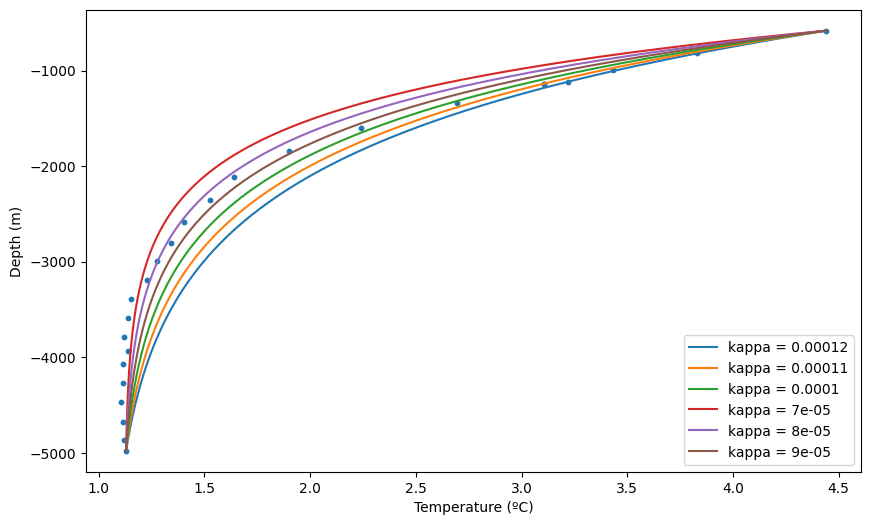

In [10]:
# Set the upwelling velocity
w = 1e-7  # m/s
# Set the diffusivity values
kappa_values = [ 0.00012, 0.00011, 0.0001, 0.00007, 0.00008, 0.00009]
#kappa_values = [1e-4, 6.8e-5, 6e-5, 8e-5, 1e-5, 5e-4]

# Create a figure and axes
plt.figure(figsize=(10, 6))

# Loop through different kappa values and solve the problem
for kappa in kappa_values:
    # Bases
    zcoord = d3.Coordinate('z')
    dist = d3.Distributor(zcoord, dtype=np.float64)
    zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
    z = dist.local_grid(zbasis)

    # Fields
    T = dist.Field(name='T', bases=zbasis)

    # Add two tau variables to allow us to apply two boundary conditions
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)

    # Substitutions
    dz = lambda A: d3.Differentiate(A, zcoord)
    Tz = dz(T) + lift(tau_1)
    Tzz = dz(Tz) + lift(tau_2)

    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - kappa*Tzz = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Plot
    Tg = T['g']
    plt.plot(Tg, z, label=f'kappa = {kappa}')

# Add labels and legend
plt.scatter(CTD_T, CTD_z, s=10)
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')
plt.legend()
plt.show()

The temperature in the upper ocean is captured well by the lowest blue line, where kappa = 1.2e-4 m^2/s, a much higher diffusivity compared to the deep ocean. But as we travel furhter into the water column, this kappa overestimates the temperature, and the slope of the experimental values agrees with the lower-kappa plots shown above.

There results imply a potential combination of the following:
 - the thermal diffusivity decreases as we travel down the water column, and there are more turbulent processes at the surface ocean; or,
 - the upwelling of cold water is stronger in the deep water to balance with the high thermal diffusivity; or
 - there is downwelling of warm water at the surface ocean and the diffusivity to strengthen the heat transfer down at surface ocean.
 - There are further ocean processes not captured by the model

 The best fit for the thermal profile is the lilac line in the above plot with a kappa = 8e05 m^2/s, which captures the average thermal diffusivity in the ocean assuming constant upwelling.

The above analysis wasn't quite right. In reality, it would be better to find a different diffusivity for different depth regions, as the curvature is set by the boundary conditions. The original temperature profile has 3 distinct gradients, so there must be a difference between them. This is because the diffusion equation can relate the temperature curvature to omega/kappa. When the diffusivity is very small, the curvature is large, as heat doesn't transmit well into the water column. When the diffusivity is large, the heat transfers easily and the gradient becomes linear between the boundaries. Let's plot each 1/3 of the points and find a well-fitting kappa for each one.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


2024-11-08 15:13:15,353 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.2e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


2024-11-08 15:13:15,463 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.3e+01/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


2024-11-08 15:13:15,588 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+01/s


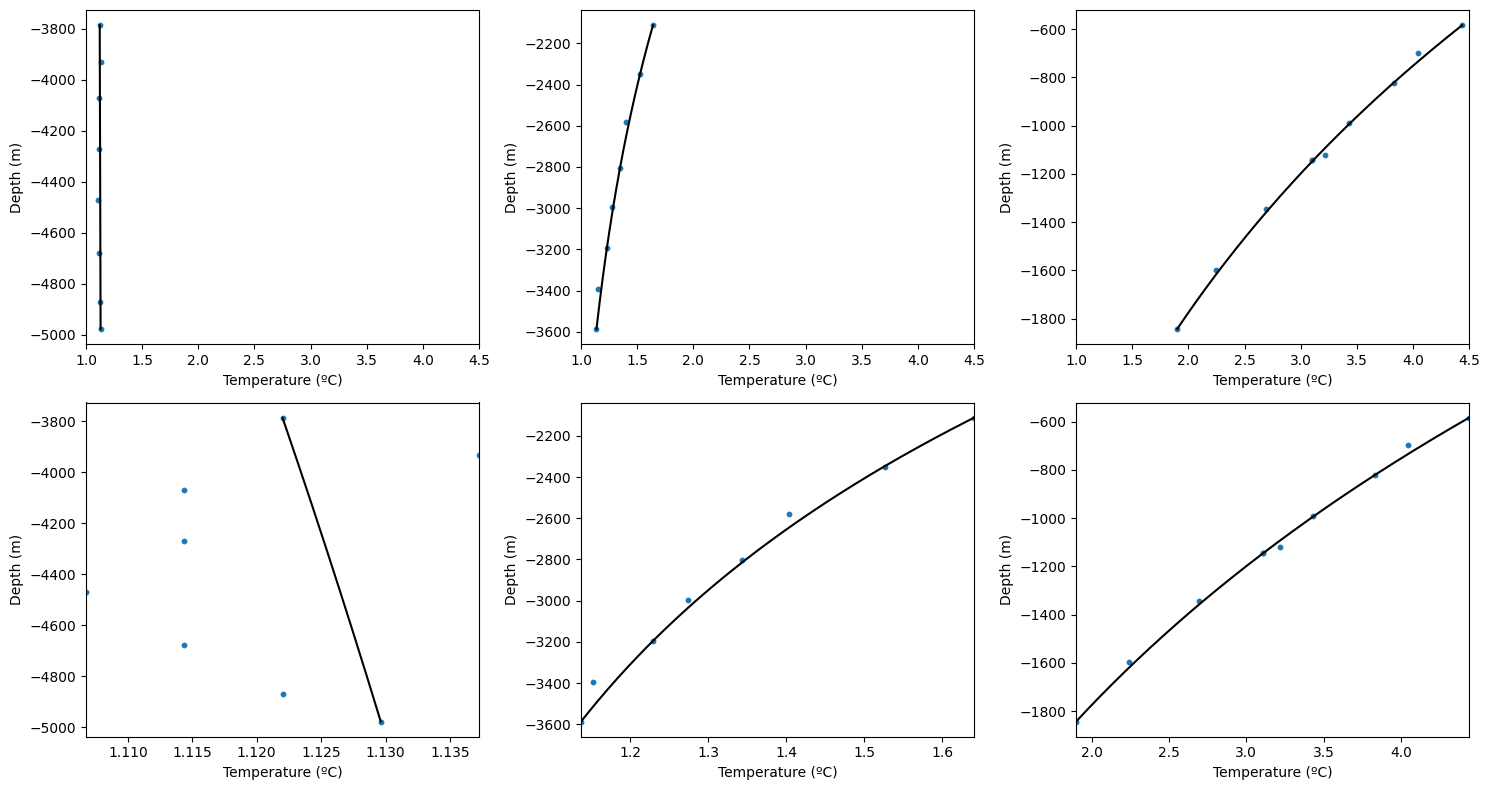

In [11]:
# Divide the data into three parts
n_data = len(CTD_T)
n_per_part = n_data // 3
data_parts = [
    (CTD_T[:n_per_part], CTD_z[:n_per_part]),
    (CTD_T[n_per_part:2 * n_per_part], CTD_z[n_per_part:2 * n_per_part]),
    (CTD_T[2 * n_per_part:], CTD_z[2 * n_per_part:]),
]

# Create a figure with 3 subplots side by side
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

# Define kappa values for each plot
kappa_values = [1e-3, 1.6e-4, 2e-4]

# Loop through each part of the data and create a plot
for i, (part_T, part_z) in enumerate(data_parts):
  z_surface = part_z[-1]
  z_bottom = part_z[0]
  T_surface = part_T[-1]
  T_bottom = part_T[0]
  Nz = 1000
  w = 1e-7
  kappa = kappa_values[i]

  # Bases
  zcoord = d3.Coordinate('z')
  dist = d3.Distributor(zcoord, dtype=np.float64)
  zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
  z = dist.local_grid(zbasis)

  # Fields
  T = dist.Field(name='T', bases=zbasis)

  # Add two tau variables to allow us to apply two boundary conditions
  tau_1 = dist.Field(name='tau_1')
  tau_2 = dist.Field(name='tau_2')
  lift_basis = zbasis.derivative_basis(1)
  lift = lambda A: d3.Lift(A, lift_basis, -1)

  # Substitutions
  dz = lambda A: d3.Differentiate(A, zcoord)
  Tz = dz(T) + lift(tau_1)
  Tzz = dz(Tz) + lift(tau_2)

  # Problem
  problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
  problem.add_equation("w*Tz - kappa*Tzz = 0")
  problem.add_equation("T(z=z_surface) = T_surface")
  problem.add_equation("T(z=z_bottom) = T_bottom")

  # Solver
  solver = problem.build_solver()
  solver.solve()

  # Plot on the corresponding subplot
  Tg = T['g']
  axes[0, i].scatter(part_T, part_z, s=10)
  axes[0, i].plot(Tg, z, 'k')
  axes[0, i].set_xlabel('Temperature (ºC)')
  axes[0, i].set_ylabel('Depth (m)')
  axes[0, i].set_xlim(1, 4.5) # Set x-axis limits

  # Plot with x-axis scaled to the dataset
  axes[1, i].scatter(part_T, part_z, s=10)
  axes[1, i].plot(Tg, z, 'k')
  axes[1, i].set_xlabel('Temperature (ºC)')
  axes[1, i].set_ylabel('Depth (m)')
  axes[1, i].set_xlim(min(part_T), max(part_T)) # Scale x-axis to the dataset

plt.tight_layout()
plt.show()

In the deepest section, kappa = 1e-3 or higher, as this gives a linear gradient.
In the mid-depths, kappa = 1.6e-4, our lowestdiffusitvity value, highest curvature
In the shallow water, kappa = 2e-4, an intermadiate diffusivity and curvature
in the very deep ocean, the temperature is linear and diffusivity high, in the upper ocean, diffusivity becomes lower. It is lowest in the middle, likely due to turbulence coming from the surface ocean (weather etc).

### 1.4 Student investigation
<a id='section1pt4'></a>
Note that the profile above is not a good fit to the data. This implies that molecular diffusion isn't sufficient to transport heat down from the surface and stop the ocean from filling up with cold, dense water.

Munk (1966) proposed that small-scale turbulence in the ocean interior results in a diffusivity that is orders of magnitude larger than the molecular value. Find a diffusivity that gives a good match with the data and test it in the Dedalus script above. Comment on the ability of this model (steady advection/diffusion) to fit the data.

ADD DISCUSSION HERE

### 1.5 Turning ocean mixing upside down

Decades of research to measure the turbulent diffusivity in the ocean consistently found values much smaller than the one predicted by Munk (1966). Specifically, while larger values of the turbulent diffusivity were found near the bottom of the ocean over rough topographic features, the values in the upper ocean were about 10x smaller than the values predicted by Munk. 50 years after Munk's seminal paper, Ferrari et al. (2016) proposed that a depth-dependent turbulent diffusivity could be balanced by <em>downwelling</em>, with negative vertical velocities in the ocean interior. In this theory, the overturning circulation is upwelling in thin boundary layers along the sloping sides of the ocean basins.

When the diffusivity, $\kappa$, is a function of $z$, the steady advection/diffusion equation can be written

$$ w\frac{dT}{dz} = \frac{d}{dz}\left(\kappa(z) \frac{dT}{dz}\right)$$

The Dedalus script below solves the previous equation and again compares the results with the observed temperature profile. For the depth-dependent diffusivity, $\kappa(z)$, we take

$$ \kappa(z)=\kappa_{bg} + (\kappa_0-\kappa_{bg})e^{-(z+D)/l} $$

using the form from Rogers et al., 2023, where $\kappa_{bg}=1\times 10^{-5} m^2/s$ is the background diffusivity characteristic of the upper water column, $\kappa_0=8.6\times 10^{-4} m^2/s$ characterizes the enhanced mixing near the bottom of the ocean, $D$ is a reference depth where $\kappa=\kappa_0$, and $l=667m$ is an exponential decay scale. In the script below, we start with $w=0$.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


2024-11-08 15:14:41,028 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.1e+00/s


Text(0, 0.5, 'Depth (m)')

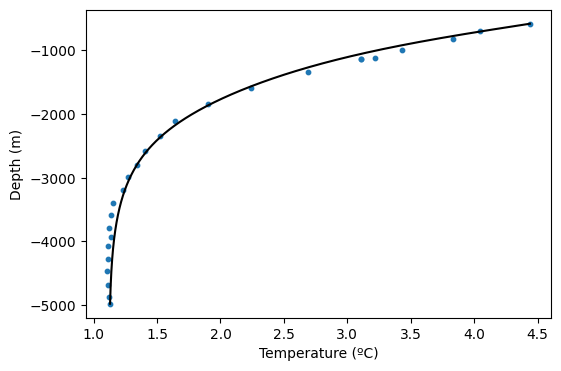

In [14]:
"""
Dedalus script to solve the steady advection/diffusion equation
with a spatially-variable diffusivity
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)

# Set various parameters. Note that the depth and the top and bottom temperature
# are taken from the CTD data in the code cell above. That cell must be run first to define CTD_T and CTD_z.
z_surface = CTD_z[-1]
z_bottom = CTD_z[0]
T_surface = CTD_T[-1]
T_bottom = CTD_T[0]
Nz = 1000

# Set the vertical velocity
w = 8e-9 # m/s Initially 0

# Bases
zcoord = d3.Coordinate('z')
dist = d3.Distributor(zcoord, dtype=np.float64)
zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
z = dist.local_grid(zbasis)

# Fields
T = dist.Field(name='T', bases=zbasis)
kappa = dist.Field(name='kappa', bases=zbasis)
# Set the diffusivity
# Below is the diffusivity profile from Rogers et al., 2023
kappa['g']=1e-5 + (8.6e-4-1e-5)*np.exp((-5e3-z)/667) # m^2/s

# Add two tau variables to allow us to apply two boundary conditions
tau_1 = dist.Field(name='tau_1')
tau_2 = dist.Field(name='tau_2')
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

# Substitutions
dz = lambda A: d3.Differentiate(A, zcoord)
Tz = dz(T) + lift(tau_1)
Tzz = dz(Tz) + lift(tau_2)

# Problem
problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
problem.add_equation("T(z=z_surface) = T_surface")
problem.add_equation("T(z=z_bottom) = T_bottom")

# Solver
solver = problem.build_solver()
solver.solve()

# Plot
plt.figure(figsize=(6, 4))
Tg=T['g']
plt.scatter(CTD_T,CTD_z,s=10)
plt.plot(Tg,z,'k')
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')

These new kappa values are quite low comapred to the previous values. Prevously, we had the (cold) upwelling balancing the higher diffusivity (trnsfer of heat down), so without this upwelling, the diffusivity must be lower to create the same profile, so most of the heat is being transpoerted by diffusion, rather than upwelling (on average). Now, the z-dependent diffusivity with a sudden exponential decrease at depth, forces a linear temperature gradient at the bottom, creating a better fit.
When w=0, upwelling balances with downwelling, although you wouldn't have both at the same time. Setting a small upwelling of 8e-9 (upwelling-downwelling balance) gives a good fit, but the top and bottow are still too hot/cold respectively. In reality, there would be strengthened downwelling from the top and upwelling from the bottom, creating an effective w that looks like a tan function about current w, which would create a perfect fit.






INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.1e+00/s


2024-11-08 15:14:47,641 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 8.1e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


2024-11-08 15:14:48,107 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


2024-11-08 15:14:48,431 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.4e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+00/s


2024-11-08 15:14:48,726 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.7e+00/s


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+00/s


2024-11-08 15:14:48,950 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 5.1e+00/s


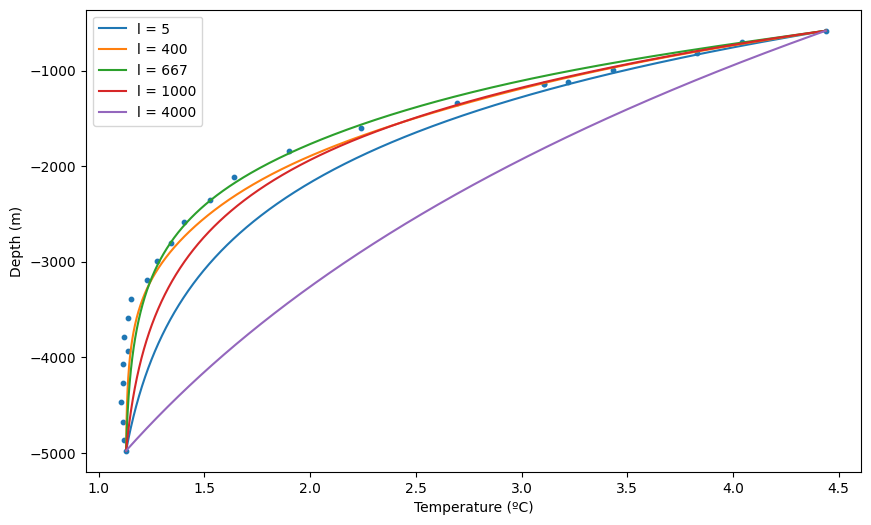

In [15]:
# Set the upwelling velocity
w = 8e-9  # m/s
# Set the diffusivity values
#kappa_values = [0.000005, 0.00001, 0.000015, 0.00002, 0.000025, 0.00003]
#kappa_values = [1e-4, 6.8e-5, 6e-5, 8e-5, 1e-5, 5e-4]
l_values = [5, 400, 667, 1000,4000]

# Create a figure and axes
plt.figure(figsize=(10, 6))

# Loop through different kappa values and solve the problem
for l in l_values:
    # Bases
    zcoord = d3.Coordinate('z')
    dist = d3.Distributor(zcoord, dtype=np.float64)
    zbasis = d3.Chebyshev(zcoord, size=Nz, bounds=(z_bottom, z_surface))
    z = dist.local_grid(zbasis)

    # Fields
    T = dist.Field(name='T', bases=zbasis)
    kappa = dist.Field(name='kappa', bases=zbasis)
    # Set the diffusivity
    # Below is the diffusivity profile from Rogers et al., 2023
    kappa['g']=1e-5 + (8.6e-4-1e-5)*np.exp((-5e3-z)/l) # m^2/s

    # Add two tau variables to allow us to apply two boundary conditions
    tau_1 = dist.Field(name='tau_1')
    tau_2 = dist.Field(name='tau_2')
    lift_basis = zbasis.derivative_basis(1)
    lift = lambda A: d3.Lift(A, lift_basis, -1)

    # Substitutions
    dz = lambda A: d3.Differentiate(A, zcoord)
    Tz = dz(T) + lift(tau_1)
    Tzz = dz(Tz) + lift(tau_2)

    # Problem
    problem = d3.LBVP([T, tau_1, tau_2], namespace=locals())
    problem.add_equation("w*Tz - dz(kappa*Tz) + lift(tau_2) = 0")
    problem.add_equation("T(z=z_surface) = T_surface")
    problem.add_equation("T(z=z_bottom) = T_bottom")

    # Solver
    solver = problem.build_solver()
    solver.solve()

    # Plot
    Tg = T['g']
    plt.plot(Tg, z, label=f'l = {l}')

# Add labels and legend
plt.scatter(CTD_T, CTD_z, s=10)
plt.xlabel('Temperature (ºC)')
plt.ylabel('Depth (m)')
plt.legend()
plt.show()

Changing l in kappa changes the characteristic length from the bottom of the ocean which defines the point at which kappa asymptotes at the Kbg value. When l is very small, the small diffusivity is almost everywhere, making the gradient curve. When l is slightly too small, the middle ocean will have too much heat transported from the surface. When l is very large, the diffusivity is overestimated almost everywhere, and the temperature is overestimated throughout, making the curve more linear. When l is too small, the middle ocean will have too much heat transported from the surface.
The curve is much less sensitive to these parameters compared to changing k manually.

The diffusivity is much higher at the floor, as there is lots of turbulence created by fluxes across the topography. The rest of the ocean has significantly less turbulence.

### 1.6 Student investigation
<a id='section1pt6'></a>
Note from the results of the script above that the density profile is reasonable, even though $w=0$. In the box below, comment on the balance in this case and what this implies about the diffusive heat flux.

Next, find a vertical velocity that produces a better agreement with the observations and report it below. Then, try varying the details of the $\kappa(z)$ profile. How sensitive is the optimal $w$ to your choice of $\kappa(z)$? What does this imply about the circulation in the ocean interior if $\kappa(z)$ varies between regions of smooth and rough topography?

(As an aside, note that the requied vertical velocity is much smaller than the one used by Munk (1966). This implies that the dense, cold water that sinks at the poles must rise elsewhere. Ferrari et al. (2016) proposed that this occurs in boundary layers near the seafloor.)

INSERT COMMENTS HERE

## 2. Transport of pollution in a river

Advection/diffusion equations are a common way to model the material transport in many physical systems. In this section we will model the transport and dilution of a pollutants added to a river.

For simplicity, we will model the river as a rectangular channel, and we will neglect depth variations. Let $x$ be the coordinate along the length of the river, and $y$ be the cross-stream coordinate. We will model the river current as

$$ u(y) = U_0\left(1-\frac{(y-w/2)^2}{(w/2)^2}\right) $$

where $w$ is the width of the river and $U_0$ is the maximum current speed which occurs at the center of the river (the $y$-coordinate will run from 0 to $w$).

Since we want to know how the pollution levels vary in time, we will solve the time-dependent advection/diffusion equation. We will model the addition of pollution by adding a spatially-dependent source term to the right hand side of the equation governing pollutant concentration:

$$ \frac{\partial c}{\partial t} + u(y)\frac{\partial c}{\partial x} = \kappa \nabla^2 c + S(x,y) $$

where $\nabla^2=(\partial_x^2 + \partial_y^2)$ is the Laplacian operator for diffusion in 2D Cartesian coordinates, and $S$ is the source term.

### 2.1 Dedalus script

The script below solves the time-dependent advection/diffusion equation with a source term.

In [16]:
"""
Script to solve the time-dependent advection/diffusion equation
"""

import numpy as np
import matplotlib.pyplot as plt
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Set parameters
U0 = 0.1 # maximum current speed in m/s. Originally 0.1
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 0.01 # diffusivity in m^2/s Originally 1e-2
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=1500 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='b', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            #logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.0e+00/s


2024-11-08 15:15:19,157 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.0e+00/s


INFO:__main__:Starting main loop


2024-11-08 15:15:19,167 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-11-08 15:15:21,737 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-11-08 15:15:21,746 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-11-08 15:15:21,754 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.312 sec


2024-11-08 15:15:21,756 solvers 0/1 INFO :: Setup time (init - iter 0): 0.312 sec


INFO:solvers:Warmup time (iter 0-10): 0.06644 sec


2024-11-08 15:15:21,762 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06644 sec


INFO:solvers:Run time (iter 10-end): 2.502 sec


2024-11-08 15:15:21,764 solvers 0/1 INFO :: Run time (iter 10-end): 2.502 sec


INFO:solvers:CPU time (iter 10-end): 0.0006949 cpu-hr


2024-11-08 15:15:21,766 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0006949 cpu-hr


INFO:solvers:Speed: 5.254e+06 mode-stages/cpu-sec


2024-11-08 15:15:21,768 solvers 0/1 INFO :: Speed: 5.254e+06 mode-stages/cpu-sec


## 2.2 Visualization

The script below makes a movie of the results from the saved variables. To run this, you need to have ffmpeg installed.  If you don't already have it installed, you can install ffmpeg with the command:

`conda install -c conda-forge ffmpeg`

In [ ]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf()
    concentration = plt.pcolor(X, Y, c_save[n,:,:].T)
    # Specify the axis limits and labels
    plt.axis('square')
    plt.xlim(0, L)
    plt.ylim(0, w)
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    plt.title('concentration, time = {0:.2f} seconds'.format(t_save[n]))
    return (concentration,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

Plotting the concentration at 5 equally spaced points in the center of the river, as the diffused will be centered there due to the parabolic velocity field.

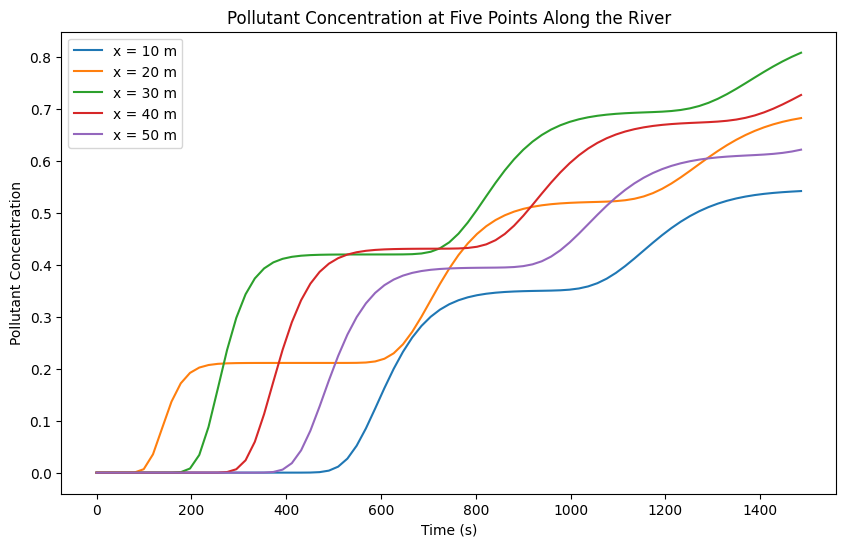

In [17]:
# Extract concentration values at five points along the river
x_points = [10, 20, 30, 40, 50]  # Example x-coordinates
y_point = w/2  # Example y-coordinate (middle of the river)

# Find the corresponding indices in the x and y arrays
x_indices = [np.argmin(np.abs(x - xp)) for xp in x_points]
y_index = np.argmin(np.abs(y - y_point))

# Extract concentration values for each point at each time step
concentrations = []
for x_index in x_indices:
    concentrations.append([c_save[i, x_index, y_index] for i in range(len(t_save))])

# Create the plot
plt.figure(figsize=(10, 6))
for i, concentration in enumerate(concentrations):
    plt.plot(t_save, concentration, label=f'x = {x_points[i]} m')

plt.xlabel('Time (s)')
plt.ylabel('Pollutant Concentration')
plt.title('Pollutant Concentration at Five Points Along the River')
plt.legend()
plt.show()

The source is at 10m and is carried up and right to the river center, so the flow passes x=20,30,40. Since it would be complicated to model a time-dependent
and changing boundary on the right hand side, we are making the river section periodic, and using the RealFourier basis to solve for the concentration. This is why x=10 is the last section of the river to see the concentration, this is the flow from the other side.
Periodically the concentration increases as more of the pollutant is added to the system and it flows thorugh.
At x=10 the edge of the tracer reaches this point; x=20,30, the tracer maximum reaches the centre of the river, and at x=40,50,10 it diffuses, reducing the local concentration. The x=10 curve then further diffuses, and is added to the x=20 curve and the others in turn, continuing the wavy concentration pattern. At late times we expect the river to become flooded with the pollutant, and the concetrations at the points being close to equal.

Now doing the same, but with a varied velocity field.

In [ ]:
# Set parameters
U0_values = [0.05, 0.1, 0.3, 5]  # Different U0 values to test
w = 10  # width of the river in m
L = 50  # length of the river section to simulate
kappa = 1e-2  # diffusivity in m^2/s
S0 = 1  # amplitude of the pollution source term
S_w = 1  # width of the source term in m
S_x = 10  # center of the forcing in x
S_y = 0  # center of the forcing in y
S_t = 1  # forcing timescale

# Numerical parameters
Nx = 256  # number of gridpoints in x
Ny = 32  # number of gridpoints in y
stop_sim_time = 1500  # end time in seconds


plt.figure(figsize=(15, 6))  # Adjust figure size for multiple plots

for i, U0 in enumerate(U0_values):
    timestep = (L / Nx) / U0  # timestep in seconds, calculated from the CFL number

    logger = logging.getLogger(__name__)

    # Bases and coordinates
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3 / 2)
    ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3 / 2)
    x, y = dist.local_grids(xbasis, ybasis)
    ex, ey = coords.unit_vector_fields(dist)  # x and y unit vectors

    # Fields
    c = dist.Field(name='b', bases=(xbasis, ybasis))
    u = dist.Field(name='u', bases=(xbasis, ybasis))
    tau_1 = dist.Field(name='tau_1', bases=xbasis)
    tau_2 = dist.Field(name='tau_2', bases=xbasis)

    # Specify the velocity field
    u['g'] = U0 * (1 - (y - w / 2) ** 2.0 / (w / 2) ** 2.0)  # parabolic velocity profile

    # Substitutions
    lift_basis = ybasis.derivative_basis(1)
    lift = lambda A: dedalus.Lift(A, lift_basis, -1)
    grad_c = dedalus.grad(c) + ey * lift(tau_1)
    dx = lambda A: dedalus.Differentiate(A, coords['x'])

    S = dist.Field(name='u', bases=(xbasis, ybasis))
    S['g'] = S0 * np.exp(-(x - S_x) ** 2.0 / S_w ** 2.0 - (y - S_y) ** 2.0 / S_w ** 2.0)

    # Problem
    problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
    problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
    problem.add_equation("c(y=0) = 0")
    problem.add_equation("c(y=w) = 0")

    # Now, set the solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Create an array to periodically save the concentration field for plotting later
    c.change_scales(1)
    c_save = [np.copy(c['g'])]

    t_save = [solver.sim_time]  # Save the initial condition and the initial time
    # Main loop
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration - 1) % 10 == 0:
                c.change_scales(1)
                c_save.append(np.copy(c['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    # Convert the variables to numpy arrays for allow array slicing
    c_save = np.array(c_save)

    # Extract concentration values at five points along the river
    x_points = [10, 20, 30, 40, 50]  # Example x-coordinates
    y_point = w / 2  # Example y-coordinate (middle of the river)

    # Find the corresponding indices in the x and y arrays
    x_indices = [np.argmin(np.abs(x - xp)) for xp in x_points]
    y_index = np.argmin(np.abs(y - y_point))

    # Extract concentration values for each point at each time step
    concentrations = []
    for x_index in x_indices:
        concentrations.append([c_save[i, x_index, y_index] for i in range(len(t_save))])

    # Create the subplot
    plt.subplot(1, len(U0_values), i + 1)
    for j, concentration in enumerate(concentrations):
        plt.plot(t_save, concentration, label=f'x = {x_points[j]} m')

    plt.xlabel('Time (s)')
    plt.ylabel('Pollutant Concentration')
    plt.title(f'U0 = {U0}')
    plt.legend()

plt.tight_layout()
plt.show()

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s


2024-11-08 15:16:43,691 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.6e+00/s


INFO:__main__:Starting main loop


2024-11-08 15:16:43,701 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-11-08 15:16:44,633 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 384


2024-11-08 15:16:44,638 solvers 0/1 INFO :: Final iteration: 384


INFO:solvers:Final sim time: 1500.0


2024-11-08 15:16:44,642 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.3255 sec


2024-11-08 15:16:44,645 solvers 0/1 INFO :: Setup time (init - iter 0): 0.3255 sec


INFO:solvers:Warmup time (iter 0-10): 0.06041 sec


2024-11-08 15:16:44,647 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06041 sec


INFO:solvers:Run time (iter 10-end): 0.8687 sec


2024-11-08 15:16:44,649 solvers 0/1 INFO :: Run time (iter 10-end): 0.8687 sec


INFO:solvers:CPU time (iter 10-end): 0.0002413 cpu-hr


2024-11-08 15:16:44,651 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0002413 cpu-hr


INFO:solvers:Speed: 7.465e+06 mode-stages/cpu-sec


2024-11-08 15:16:44,653 solvers 0/1 INFO :: Speed: 7.465e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.1e+00/s


2024-11-08 15:16:44,984 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.1e+00/s


INFO:__main__:Starting main loop


2024-11-08 15:16:44,990 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-11-08 15:16:46,843 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 768


2024-11-08 15:16:46,848 solvers 0/1 INFO :: Final iteration: 768


INFO:solvers:Final sim time: 1500.0


2024-11-08 15:16:46,856 solvers 0/1 INFO :: Final sim time: 1500.0


INFO:solvers:Setup time (init - iter 0): 0.2849 sec


2024-11-08 15:16:46,859 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2849 sec


INFO:solvers:Warmup time (iter 0-10): 0.05223 sec


2024-11-08 15:16:46,862 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.05223 sec


INFO:solvers:Run time (iter 10-end): 1.798 sec


2024-11-08 15:16:46,865 solvers 0/1 INFO :: Run time (iter 10-end): 1.798 sec


INFO:solvers:CPU time (iter 10-end): 0.0004995 cpu-hr


2024-11-08 15:16:46,867 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0004995 cpu-hr


INFO:solvers:Speed: 7.31e+06 mode-stages/cpu-sec


2024-11-08 15:16:46,870 solvers 0/1 INFO :: Speed: 7.31e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+00/s


2024-11-08 15:16:47,196 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+00/s


INFO:__main__:Starting main loop


2024-11-08 15:16:47,203 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-11-08 15:16:53,930 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2304


2024-11-08 15:16:53,934 solvers 0/1 INFO :: Final iteration: 2304


INFO:solvers:Final sim time: 1500.0000000000316


2024-11-08 15:16:53,939 solvers 0/1 INFO :: Final sim time: 1500.0000000000316


INFO:solvers:Setup time (init - iter 0): 0.2762 sec


2024-11-08 15:16:53,941 solvers 0/1 INFO :: Setup time (init - iter 0): 0.2762 sec


INFO:solvers:Warmup time (iter 0-10): 0.06031 sec


2024-11-08 15:16:53,944 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.06031 sec


INFO:solvers:Run time (iter 10-end): 6.663 sec


2024-11-08 15:16:53,946 solvers 0/1 INFO :: Run time (iter 10-end): 6.663 sec


INFO:solvers:CPU time (iter 10-end): 0.001851 cpu-hr


2024-11-08 15:16:53,948 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001851 cpu-hr


INFO:solvers:Speed: 5.97e+06 mode-stages/cpu-sec


2024-11-08 15:16:53,951 solvers 0/1 INFO :: Speed: 5.97e+06 mode-stages/cpu-sec


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s


2024-11-08 15:16:54,316 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 3.9e+00/s


INFO:__main__:Starting main loop


2024-11-08 15:16:54,323 __main__ 0/1 INFO :: Starting main loop


At U0=0.05, the relatively increased pollutant diffusion allows the tracer to reach x=10 before passing through the boundary. The tracer also travels to the river centre first, so x=10 sees the highest pollutant concentration before it diffuses outwards.
At U0 = 0.3, the pattern due to the periodic nature of the problem continues as the river becomes flooded with the pollutant.
At U0 = 5, the pollutant concentration increase is, surprisingly, not linear, but has the same curve as U=0.3. This may be a computational artefact, or caused by the constant outward diffusion of the pollutant from the center (since the curves have the same timescale).

Now looking at different diffusivities

In [ ]:
# Set parameters
U0 = 0.1  # Different U0 values to test
w = 10  # width of the river in m
L = 50  # length of the river section to simulate
kappa_values = [1e-1, 1e-2, 1e-3, 1e-4]  # diffusivity in m^2/s
S0 = 1  # amplitude of the pollution source term
S_w = 1  # width of the source term in m
S_x = 10  # center of the forcing in x
S_y = 0  # center of the forcing in y
S_t = 1  # forcing timescale

# Numerical parameters
Nx = 256  # number of gridpoints in x
Ny = 32  # number of gridpoints in y
stop_sim_time = 1500  # end time in seconds


plt.figure(figsize=(15, 6))  # Adjust figure size for multiple plots

for i, kappa in enumerate(kappa_values):
    timestep = (L / Nx) / U0  # timestep in seconds, calculated from the CFL number

    logger = logging.getLogger(__name__)

    # Bases and coordinates
    coords = dedalus.CartesianCoordinates('x', 'y')
    dist = dedalus.Distributor(coords, dtype=np.float64)
    xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3 / 2)
    ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3 / 2)
    x, y = dist.local_grids(xbasis, ybasis)
    ex, ey = coords.unit_vector_fields(dist)  # x and y unit vectors

    # Fields
    c = dist.Field(name='b', bases=(xbasis, ybasis))
    u = dist.Field(name='u', bases=(xbasis, ybasis))
    tau_1 = dist.Field(name='tau_1', bases=xbasis)
    tau_2 = dist.Field(name='tau_2', bases=xbasis)

    # Specify the velocity field
    u['g'] = U0 * (1 - (y - w / 2) ** 2.0 / (w / 2) ** 2.0)  # parabolic velocity profile

    # Substitutions
    lift_basis = ybasis.derivative_basis(1)
    lift = lambda A: dedalus.Lift(A, lift_basis, -1)
    grad_c = dedalus.grad(c) + ey * lift(tau_1)
    dx = lambda A: dedalus.Differentiate(A, coords['x'])

    S = dist.Field(name='u', bases=(xbasis, ybasis))
    S['g'] = S0 * np.exp(-(x - S_x) ** 2.0 / S_w ** 2.0 - (y - S_y) ** 2.0 / S_w ** 2.0)

    # Problem
    problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
    problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
    problem.add_equation("c(y=0) = 0")
    problem.add_equation("c(y=w) = 0")

    # Now, set the solver
    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    # Create an array to periodically save the concentration field for plotting later
    c.change_scales(1)
    c_save = [np.copy(c['g'])]

    t_save = [solver.sim_time]  # Save the initial condition and the initial time
    # Main loop
    try:
        logger.info('Starting main loop')
        while solver.proceed:
            solver.step(timestep)
            if (solver.iteration - 1) % 10 == 0:
                c.change_scales(1)
                c_save.append(np.copy(c['g']))
                t_save.append(solver.sim_time)
    except:
        logger.error('Exception raised, triggering end of main loop.')
        raise
    finally:
        solver.log_stats()

    # Convert the variables to numpy arrays for allow array slicing
    c_save = np.array(c_save)

    # Extract concentration values at five points along the river
    x_points = [10, 20, 30, 40, 50]  # Example x-coordinates
    y_point = w / 2  # Example y-coordinate (middle of the river)

    # Find the corresponding indices in the x and y arrays
    x_indices = [np.argmin(np.abs(x - xp)) for xp in x_points]
    y_index = np.argmin(np.abs(y - y_point))

    # Extract concentration values for each point at each time step
    concentrations = []
    for x_index in x_indices:
        concentrations.append([c_save[i, x_index, y_index] for i in range(len(t_save))])

    # Create the subplot
    plt.subplot(1, len(kappa_values), i + 1)
    for j, concentration in enumerate(concentrations):
        plt.plot(t_save, concentration, label=f'x = {x_points[j]} m')

    plt.xlabel('Time (s)')
    plt.ylabel('Pollutant Concentration')
    plt.title(f'Diffusivity = {kappa}')
    plt.legend()

plt.tight_layout()
plt.show()

Kappa = 0.1: pollutant diffuses immediately, to reach x=10,20, but diffuses greatly across the river before reaching x=30 onwards. Lower concentrations because of this.
Kappa = 0.001: pollutant only reaches the center on its second 'round'. Expect to see a more linear pattern at higher velocity fields and longer timescales, compared to k=0.01.
Kappa = 0.0001: The Chebyshev basis can't deal with such a low diffusivity.


Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

Scaling the diffusion equation gives t ~ y^2 / kappa. y = length of travel for the pollutant. This will be the distance the edge of the source will travel. Sice the source is a gaussian starting at 0, the concentration will become 0.003 at around 3Sw (propery of Gaussian. So, y=7. kappa = 0.01.
Time to reach opposite end = 49/0.01 = 4900s. Taking the average speed of the parabolic velocity as 0.67m/s, this should be d = vt = 0.067*4900 = 328m.



INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


2024-11-08 14:57:44,696 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s


INFO:__main__:Starting main loop


2024-11-08 14:57:44,707 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2024-11-08 14:57:51,283 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2560


2024-11-08 14:57:51,287 solvers 0/1 INFO :: Final iteration: 2560


INFO:solvers:Final sim time: 5000.0


2024-11-08 14:57:51,293 solvers 0/1 INFO :: Final sim time: 5000.0


INFO:solvers:Setup time (init - iter 0): 0.4835 sec


2024-11-08 14:57:51,296 solvers 0/1 INFO :: Setup time (init - iter 0): 0.4835 sec


INFO:solvers:Warmup time (iter 0-10): 0.0924 sec


2024-11-08 14:57:51,299 solvers 0/1 INFO :: Warmup time (iter 0-10): 0.0924 sec


INFO:solvers:Run time (iter 10-end): 6.471 sec


2024-11-08 14:57:51,302 solvers 0/1 INFO :: Run time (iter 10-end): 6.471 sec


INFO:solvers:CPU time (iter 10-end): 0.001798 cpu-hr


2024-11-08 14:57:51,304 solvers 0/1 INFO :: CPU time (iter 10-end): 0.001798 cpu-hr


INFO:solvers:Speed: 6.833e+06 mode-stages/cpu-sec


2024-11-08 14:57:51,306 solvers 0/1 INFO :: Speed: 6.833e+06 mode-stages/cpu-sec


2024-11-08 14:57:51,349 matplotlib.legend 0/1 WARNING :: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


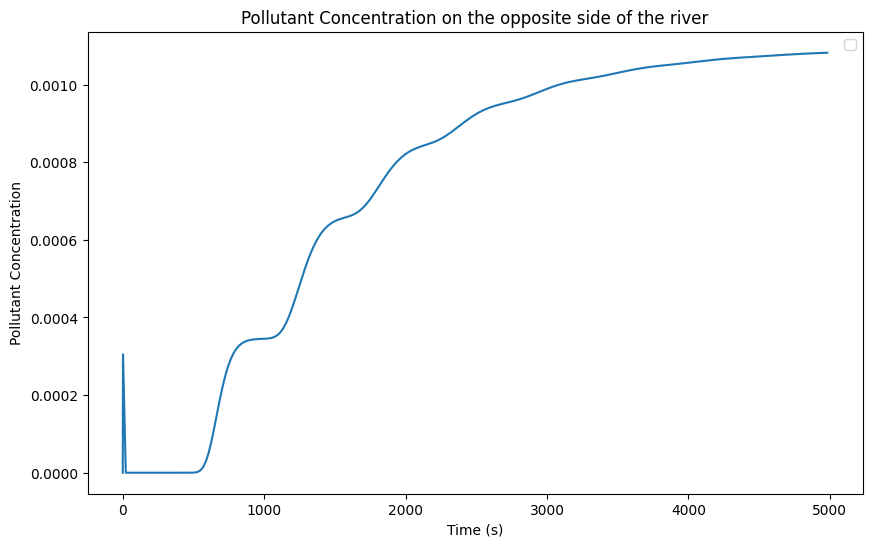

The first time the pollutant concentration at x=10 and y=10 is above 0.000005 after 400s is: 548.828125 seconds


In [6]:
# Set parameters
U0 = 0.1 # maximum current speed in m/s. Originally 0.1
w = 10 # width of the river in m
L = 50 # length of the river section to simulate
kappa = 0.01 # diffusivity in m^2/s Originally 1e-2
S0 = 1 # amplitude of the pollution source term
S_w = 1 # width of the source term in m
S_x = 10 # center of the forcing in x
S_y = 0 # center of the forcing in y
S_t = 1 # forcing timescale

# Numerical parameters
Nx = 256 # number of gridoints in x
Ny = 32 # number of gridpoints in y
stop_sim_time=5000 # end time in seconds
timestep = (L/Nx)/U0 # timestep in seconds, calculated from the CFL number

import numpy as np
import dedalus.public as dedalus
import logging
logger = logging.getLogger(__name__)

# Bases and coordinates
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(0, L), dealias=3/2)
ybasis = dedalus.ChebyshevT(coords['y'], size=Ny, bounds=(0, w), dealias=3/2)
x, y = dist.local_grids(xbasis, ybasis)
ex, ey = coords.unit_vector_fields(dist) # x and y unit vectors

# Fields
c = dist.Field(name='b', bases=(xbasis,ybasis))
u = dist.Field(name='u', bases=(xbasis,ybasis))
tau_1 = dist.Field(name='tau_1', bases=xbasis)
tau_2 = dist.Field(name='tau_2', bases=xbasis)

# Specify the velocity field
u['g'] = U0 * (1- (y - w/2)**2.0/(w/2)**2.0) # parabolic velocity profile

# Substitutions
lift_basis = ybasis.derivative_basis(1)
lift = lambda A: dedalus.Lift(A, lift_basis, -1)
grad_c = dedalus.grad(c) + ey*lift(tau_1)
dx = lambda A: dedalus.Differentiate(A, coords['x'])

S = dist.Field(name='u', bases=(xbasis,ybasis))
S['g'] = S0*np.exp(-(x-S_x)**2.0/S_w**2.0-(y-S_y)**2.0/S_w**2.0)

# Problem
problem = dedalus.IVP([c, tau_1, tau_2], namespace=locals())
problem.add_equation("dt(c) + u*dx(c) - kappa*div(grad_c) + lift(tau_2) = S/S_t")
problem.add_equation("c(y=0) = 0")
problem.add_equation("c(y=w) = 0")

# Now, set the solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Create an array to periodically save the concentration field for plotting later
c.change_scales(1)
c_save = [np.copy(c['g'])];

t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            #logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            c.change_scales(1)
            c_save.append(np.copy(c['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

# Convert the variables to numpy arrays for allow array slicing
c_save = np.array(c_save)

# Extract concentration values at five points along the river
x_point = 10  # Example x-coordinates
y_point = 10  # Example y-coordinate (middle of the river)

# Find the corresponding indices in the x and y arrays
x_index = [np.argmin(np.abs(x - x_point))]
y_index = np.argmin(np.abs(y - y_point))

# Extract concentration values for each point at each time step
concentrations = []
concentrations.append([c_save[i, x_index, y_index] for i in range(len(t_save))])

# Create the plot
plt.figure(figsize=(10, 6))
for i, concentration in enumerate(concentrations):
    plt.plot(t_save, concentration)

plt.xlabel('Time (s)')
plt.ylabel('Pollutant Concentration')
plt.title('Pollutant Concentration on the opposite side of the river')
plt.legend()
plt.show()

time_above_threshold = None
for i in range(len(t_save)):
  if t_save[i] > 400 and c_save[i, x_index[0], y_index] > 0.000005:
    time_above_threshold = t_save[i]
    break

if time_above_threshold:
  print(
      f"The first time the pollutant concentration at x={x_point} and y={y_point} is above 0.000005 after 400s is: {time_above_threshold} seconds"
  )

There is an odd spike at the top river edge at x=10, and I'm unsure why it has appeared. It is highest here, and only appears at the opposite side of the source. I believe it is an artefact of the Chebyshev basis.
The tracer reaches the other side after 549s. Taking Umean = 0.067m/s again.
Roughly, x = 0.075 * 549 = 37m.

This is much smaller than the scaled 328m, but both results have the same order of magnitude. It may be that the maximal extend of the initial source is significant at higher values. The scaling result also only gives an estimate without solving the equation.

## 2.3 Student investigation
<a id='section2pt3'></a>
In the boxes below, plot the pollution concentration at a few points as a function of time. Then vary the maximum flow speed and the diffusivity and explore how the pollution levels depend on these parameters. Using dimensional analysis, estimate the time needed for the pollution to reach the opposite side of the river. How far downstream of the source do you expect this to happen (assuming that the domain in the x-direction is infinite).

INSERT PLOTS AND COMMENTS HERE

## 3. Optional further investigations

* In the river pollution example, you might notice that the concentration field is mixed more effectively in the x-direction than in the y-direction. The combination of differential advection by the currents and cross-stream diffusion is very effective at mixing the plume in the x-direction. This is an example of Taylor dispersion (Taylor, 1953). Construct numerical experiments to quantify Taylor dispersion and its dependence on the current shear and the diffusivity. You could also separate the diffusivity into parts in the x and y directions with different coefficients.  If you set the x-component of the diffusivity to zero, then any spreading of the concentration in the x-direction should be due to Taylor dispersion.

* Try making the river speed a function of time. The easiest way to do this is to add a new equation so that Dedalus solves for the velocity in addition to the concentration field. For example, you could make the river speed decrease exponentially in time, or it could be sinusoidal in time.

* In the ocean mixing example, if $\kappa$ is a function of $x$ and $z$, what would this imply about the velocity field? You could even try writing a Dedalus script to solve the 2D advection/diffusion equation with a prescribed spatially-dependent $\kappa(x,z)$.


### References

Munk, W.H., 1966. Abyssal recipes. In Deep sea research and oceanographic abstracts (Vol. 13, No. 4, pp. 707-730). Elsevier.

Ferrari, R., Mashayek, A., McDougall, T.J., Nikurashin, M. and Campin, J.M., 2016. Turning ocean mixing upside down. Journal of Physical Oceanography, 46(7), pp.2239-2261.

Taylor, G.I., 1953. Dispersion of soluble matter in solvent flowing slowly through a tube. Proceedings of the Royal Society of London. Series A. Mathematical and Physical Sciences, 219(1137), pp.186-203.